In [1]:
import torch
import os
import sys
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

one_level_higher = os.path.abspath(os.path.join(os.getcwd(), ".."))
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
gnn_project_dir = os.path.abspath(os.path.join(ppp_dir, ".."))
additional_paths = [one_level_higher, ppp_dir, gnn_project_dir]

for a_path in additional_paths:
    if a_path not in sys.path:
        sys.path.insert(0, a_path)


from model_parametrized.pinn_ff import PINNff
from ode_dataset import ODEData
from config import HyperparamConfig

In [2]:
### REGIME !!!
regime_str = "low_regime"

### WANDB PROJECT NAME !!!
wandb_project_name = f"gnn_1d_logistic_pinnff_{regime_str}"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: padieul to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
base_dir = Path(".") / f"{regime_str}" # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [4]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


### Configure initial dataset and hyperparameters

In [5]:
config = HyperparamConfig(
    total_i=500,
    dataset="1d-logistic-ode",
    model_name="pinn_ff",  # Model name
    init_activ_func="sin",
    subseq_activ_func="tanh",
    in_dim=3,
    hidden_dim=256,
    out_dim=1,
    num_layer=4,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=128
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 500, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'sin', 'subseq_activ_func': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\rho$ parameter variance datasets, adam optimizer with mini batching

In [6]:
def compute_relative_errors(model, dataset, rho, device):
    
    # Get test points for the current rho
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 1)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [7]:
import torch
import wandb
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [8]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, rho_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        rho_values (list): List of rho values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project=wandb_project_name,
        config=config_dict,
        settings=wandb.Settings(silent=True)
    )

    momentum_dict = {}  # Reset for each run
    loss_track = {}
    model.train() # set to training mode

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_ic = 0.0
        num_batches = 0

        for rho in rho_values:
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            x_ic, t_ic, rho_ic, u_ic = dataset.get_initial_condition(rho)

            for bx, bt, brho in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                pred_ic = model(x_ic.to(device), t_ic.to(device), rho_ic.to(device))

                if config_dict["normalize_ic"]:
                    normalized_ic_error = (pred_ic - u_ic.to(device)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_ic - u_ic.to(device)) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                total_loss_res += loss_res.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

        avg_loss_res = total_loss_res / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for rho in rho_values:
            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
            wandb_dict[f"{rho}_rl1"] = rl1
            wandb_dict[f"{rho}_rl2"] = rl2
            total_l1 += rl1 
            total_l2 += rl2

        average_l1 = total_l1 / len(rho_values) 
        average_l2 = total_l2 / len(rho_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

### Hyperparameter tuning through grid search

##### Tuning step 1

We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. different model configurations (initial layer types, subsequent layer types)

Other params remain unchanged:
- `iteration_steps` - **fixed value**! (low)
- `num_layers` - **fixed value**!
- `hidden_dim` - **fixed value**!

**Also:** Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [10]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0] # small range

# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and rho_values.
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')


# === Variations ===
normalize_res_values = [False] #[True, False]
normalize_ic_values = [False] #[True, False]
adaptive_loss = [(True,0.7), (True, 0.9), (False, None)]
alpha_values = [None] #[0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [None] #[0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [100] #[50, 100, 400]
models = []


for init_act,subseq_act, hidden_d, num_layers in [("tanh", "tanh", 128,2),("sin", "tanh", 128, 2), ("sin","gelu", 128, 2), ("tanh", "gelu", 128,2)]:
    model = PINNff(in_dim=config.in_dim, 
                   hidden_dim=hidden_d,
                   out_dim=config.out_dim,
                   num_layer=num_layers,
                   init_act_func=init_act,
                   subseq_activ_func=subseq_act).to(device)
    model.apply(init_weights)
    models.append((model,init_act, subseq_act, hidden_d, num_layers))


# === Grid Search ===
best_model1 = None
best_config1 = None
best_l11 = float('inf')
best_l21 = float('inf')

for model,i_act,s_act, hidden_d, num_layers in models: 
    for normalize_res in normalize_res_values:
        for normalize_ic in normalize_ic_values:
            for a_loss, a_coeff in adaptive_loss:
                for alpha in alpha_values:
                    for epsilon in epsilon_values:
                        for total_i in iteration_steps:
                            config.normalize_res = normalize_res
                            config.normalize_ic = normalize_ic
                            config.adaptive_loss_coeff = a_coeff
                            config.alpha = alpha
                            config.epsilon = epsilon
                            config.total_i = total_i
                            config.adaptive_loss_weighting = a_loss
                            config.init_activ_func = i_act 
                            config.subseq_activ_func = s_act
                            config.hidden_dim = hidden_d 
                            config.num_layer = num_layers
                            config.validate()

                            # Call the training function
                            config_dict = config.to_dict()
                            if config.optimizer == "adam":
                                optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                            loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                            # Update the best model if the current one is better
                            if avg_l1 < best_l11 and avg_l2 < best_l21:
                                best_model1 = model
                                best_config1 = config_dict.copy()
                                best_l11 = avg_l1
                                best_l21 = avg_l2

# Print the best model and configuration
print("Best Model Configuration:")
print(best_config1)
print(f"Best Average L1 Error: {best_l11}")
print(f"Best Average L2 Error: {best_l21}")

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\prdie\OneDrive\Sources\pinnsformer\gnn_project\gnn_project_env\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Best Model Configuration:
{'total_i': 100, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 128, 'out_dim': 1, 'num_layer': 2, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}
Best Average L1 Error: 0.11324305832386017
Best Average L2 Error: 0.11854502558708191


In [11]:
def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 2  # Fixed: Row 1 for predictions, Row 2 for errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.plot(pred, label="Prediction", color="blue", linewidth=2)
        ax_pred.plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("t - Time")  # Horizontal axis label
        ax_pred.set_ylabel("u(t) - Value")  # Vertical axis label
        ax_pred.legend()
        

        # Plot absolute and percentage errors (Row 2)
        ax_err = axes[1, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        ax_err.set_xlabel("t - Time")  # Horizontal axis label
        ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [12]:
def test_on_parameter_range(rho_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for rho in rho_values:
        # Get test points for the current rho
        x_test, t_test, _ = dataset.get_test_points(rho)
        rho_test = torch.full_like(x_test, rho).to(device)

        # Compute analytical solution
        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

        # Compute best model predictions
        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
            pred = pred.cpu().detach().numpy().reshape(-1)

        # Compute error
        error = np.abs(u_analytical - pred)

        # Store results
        predictions[rho] = pred
        analytical_solutions[rho] = u_analytical
        errors[rho] = error

    return predictions, analytical_solutions, errors

Figure saved to low_regime\images\predictions_and_errors_v1.png


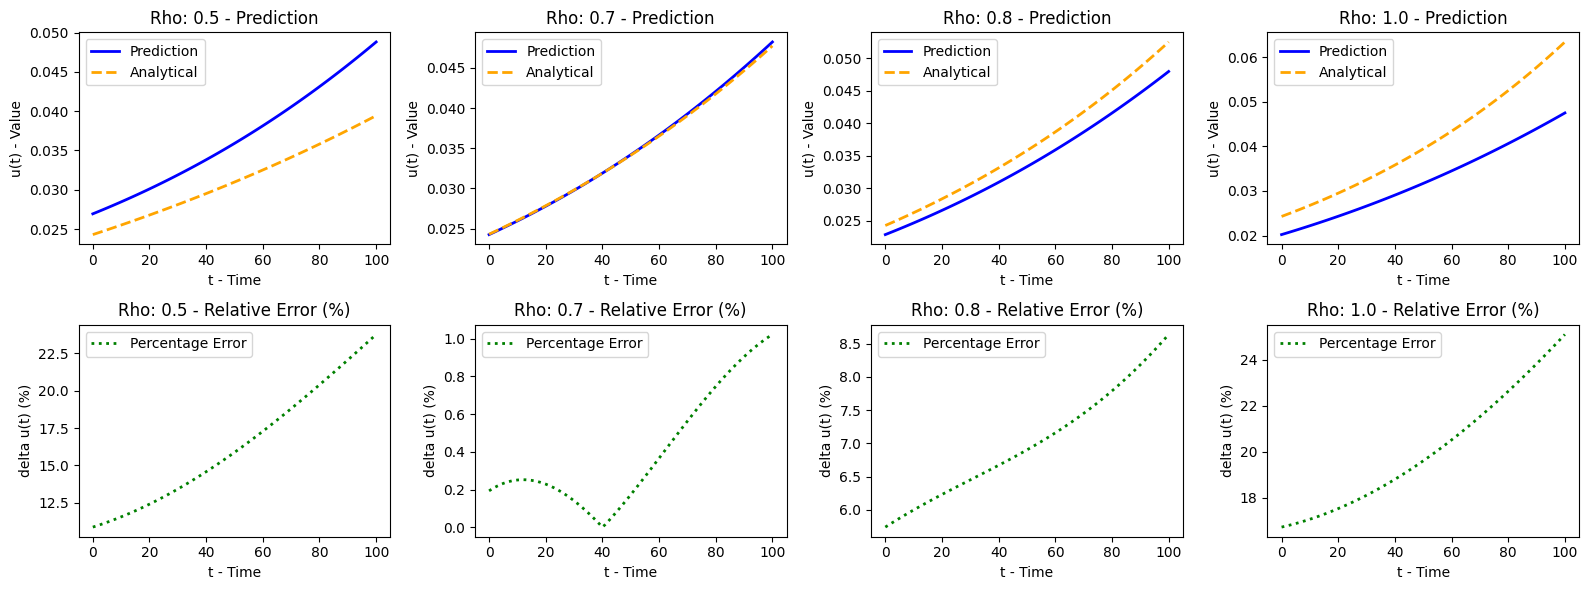

In [13]:
best_model1.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model1)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_v1.png"
)

##### Tuning step 2
We use the lessons of tuning step 1 to inform our tuning for step 2.

We explore the impact of the following params on convergence and performance:
1. adaptive_loss - off
2. different `hidden_dim` values
3. different `num_layer` values
3. 2 differnt model configurations (tanh, tanh) and (tanh, gelu)
4. different iterations step values

Other params remain unchanged:
- adaptive loss - **fixed value**!

**Also:** Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [15]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0] # small range

# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and rho_values.
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')


# === Variations ===
normalize_res_values = [False] #[True, False]
normalize_ic_values = [False] #[True, False]
adaptive_loss = [(False, None)] #[(True,0.7), (True, 0.9), (False, None)]
alpha_values = [None] #[0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [None] #[0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [150,200] #[50, 100, 400]
model_variants = [
    ("tanh", "tanh", 128, 2),
    ("tanh", "tanh", 128, 3),
    ("tanh", "tanh", 128, 4),
    ("tanh", "gelu", 128, 2),
    ("tanh", "gelu", 128, 3),
    ("tanh", "gelu", 128, 4),
    ("tanh", "tanh", 256, 2),
    ("tanh", "tanh", 256, 3),
    ("tanh", "tanh", 256, 4),
    ("tanh", "gelu", 256, 2),
    ("tanh", "gelu", 256, 3),
    ("tanh", "gelu", 256, 4),
    

]


models = []
for init_act,subseq_act, hidden_d, num_layers in model_variants:
    model = PINNff(in_dim=config.in_dim, 
                   hidden_dim=hidden_d,
                   out_dim=config.out_dim,
                   num_layer=num_layers,
                   init_act_func=init_act,
                   subseq_activ_func=subseq_act).to(device)
    model.apply(init_weights)
    models.append((model,init_act, subseq_act, hidden_d, num_layers))


# === Grid Search ===
best_model2 = None
best_config2 = None
best_l12 = float('inf')
best_l22 = float('inf')

for model,i_act,s_act, hidden_d, num_layers in models: 
    for normalize_res in normalize_res_values:
        for normalize_ic in normalize_ic_values:
            for a_loss, a_coeff in adaptive_loss:
                for alpha in alpha_values:
                    for epsilon in epsilon_values:
                        for total_i in iteration_steps:
                            config.normalize_res = normalize_res
                            config.normalize_ic = normalize_ic
                            config.adaptive_loss_coeff = a_coeff
                            config.alpha = alpha
                            config.epsilon = epsilon
                            config.total_i = total_i
                            config.adaptive_loss_weighting = a_loss
                            config.init_activ_func = i_act 
                            config.subseq_activ_func = s_act
                            config.hidden_dim = hidden_d 
                            config.num_layer = num_layers
                            config.validate()

                            # Call the training function
                            config_dict = config.to_dict()
                            if config.optimizer == "adam":
                                optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                            loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                            # Update the best model if the current one is better
                            if avg_l1 < best_l12 and avg_l2 < best_l22:
                                best_model2 = model
                                best_config1 = config_dict.copy()
                                best_l12 = avg_l1
                                best_l22 = avg_l2

# Print the best model and configuration
print("Best Model Configuration:")
print(best_config2)
print(f"Best Average L1 Error: {best_l12}")
print(f"Best Average L2 Error: {best_l22}")

100%|██████████| 150/150 [00:18<00:00,  8.30it/s]


100%|██████████| 200/200 [00:24<00:00,  8.32it/s]


100%|██████████| 150/150 [00:19<00:00,  7.56it/s]


100%|██████████| 200/200 [00:26<00:00,  7.51it/s]


100%|██████████| 150/150 [00:21<00:00,  6.91it/s]


100%|██████████| 200/200 [00:31<00:00,  6.45it/s]


100%|██████████| 150/150 [00:21<00:00,  6.92it/s]


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


100%|██████████| 200/200 [00:30<00:00,  6.47it/s]


100%|██████████| 150/150 [00:25<00:00,  6.00it/s]


100%|██████████| 200/200 [00:31<00:00,  6.42it/s]


100%|██████████| 150/150 [00:21<00:00,  6.94it/s]


100%|██████████| 200/200 [00:28<00:00,  7.08it/s]


100%|██████████| 150/150 [00:21<00:00,  6.84it/s]


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


100%|██████████| 150/150 [00:23<00:00,  6.31it/s]


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


100%|██████████| 150/150 [00:23<00:00,  6.32it/s]


100%|██████████| 200/200 [00:28<00:00,  6.93it/s]


100%|██████████| 150/150 [00:22<00:00,  6.59it/s]


100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


100%|██████████| 150/150 [00:23<00:00,  6.27it/s]


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


Best Model Configuration:
None
Best Average L1 Error: 0.011002150364220142
Best Average L2 Error: 0.01290023885667324


Figure saved to low_regime\images\predictions_and_errors_v2.png


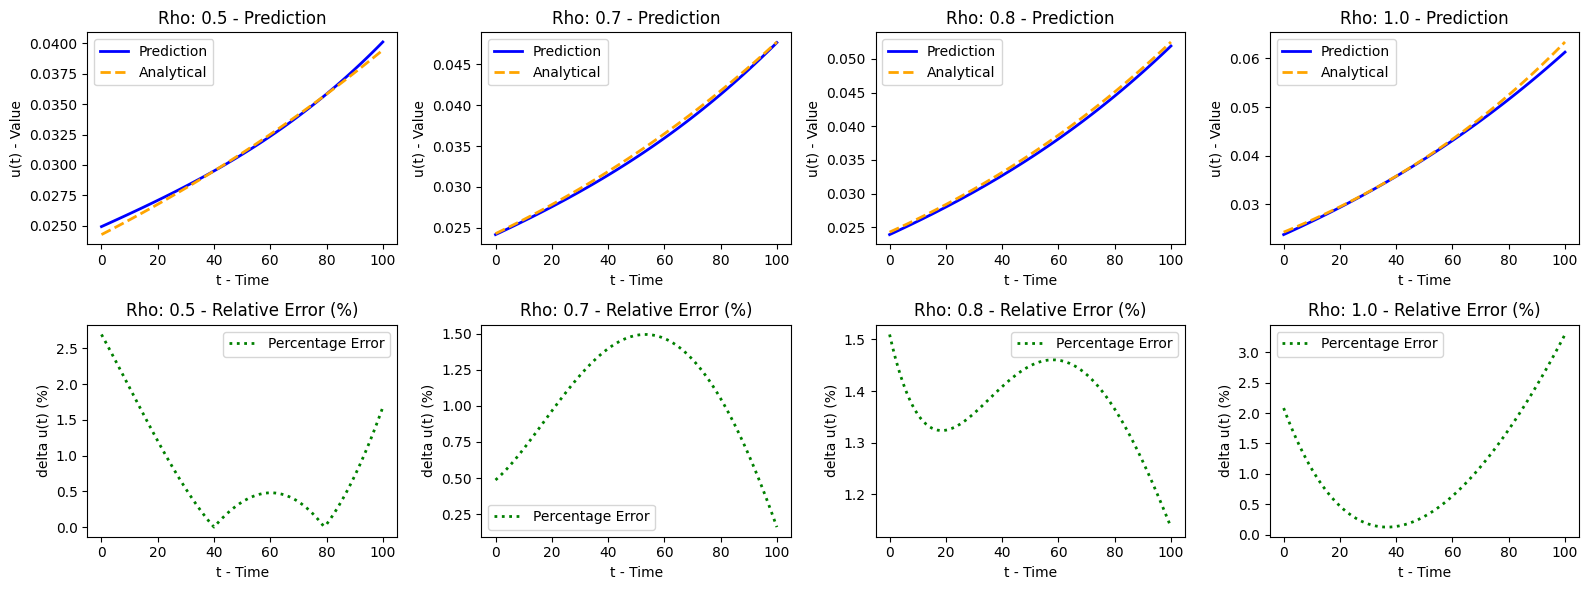

In [16]:
best_model2.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model2)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_v2.png"
)

### Testing best model on different rho ranges


In [ ]:
load_existing_model = False

if load_existing_model == True:
    best_model = PINNff(
        in_dim=3,  # Input dimension (e.g., x, t, rho)
        hidden_dim=256,  # Hidden layer size (must match the saved model)
        out_dim=1,  # Output dimension
        num_layer=4,  # Number of layers
        init_act_func="tanh",  # Initial activation function
        subseq_activ_func="gelu"  # Subsequent activation function
    ).to(device)

    # Load the model weights
    model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()  # Set the model to evaluation mode

    print("Model loaded successfully!")

In [ ]:
# if needed
#%pip install seaborn scipy

In [19]:
# from previous tuning experiments we select the best model
best_config = best_config2
best_model = best_model2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import torch

# Function 1: Generate uniformly spaced ρ values in a given range
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_rho_range(rho_values, dataset, model, device='cpu'):
    results = []

    for rho in rho_values:
        x_test, t_test, _ = dataset.get_interior_input_without_points()
        rho_test = torch.full_like(x_test, rho).to(device)

        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0]
            pred = pred.cpu().detach().numpy().reshape(-1)

        rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
        rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

        results.append({'rho': rho, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_rho(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['rho'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['rho'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['rho'], df['rl1'])
    p_l2, _ = pearsonr(df['rho'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


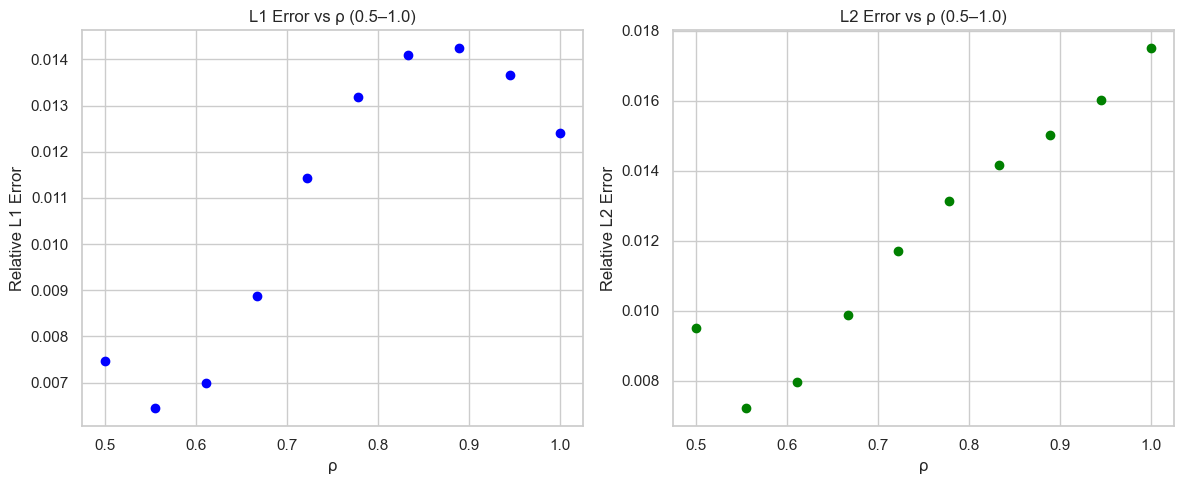

Pearson correlation (ρ vs L1): 0.874
Pearson correlation (ρ vs L2): 0.957


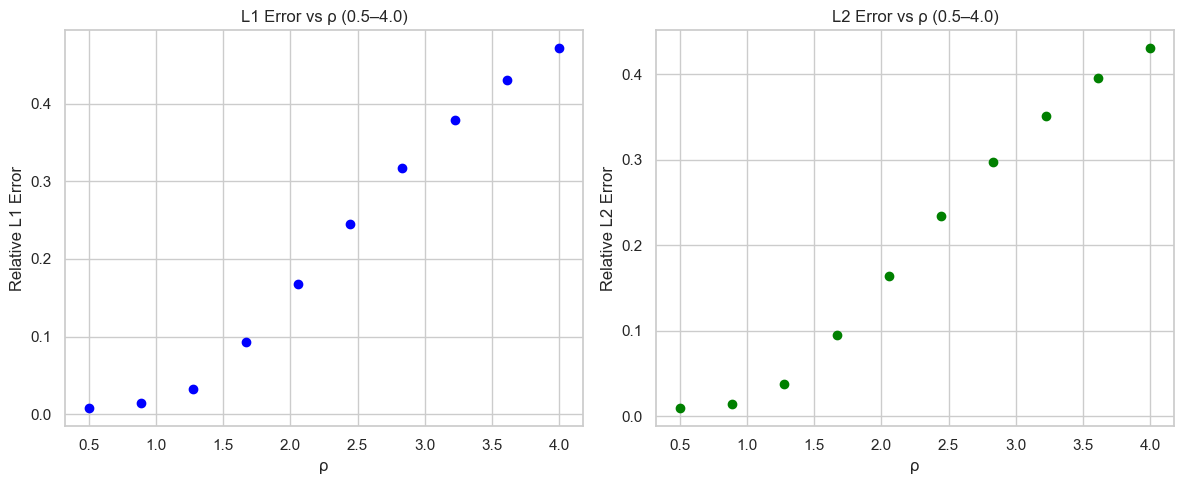

Pearson correlation (ρ vs L1): 0.988
Pearson correlation (ρ vs L2): 0.990


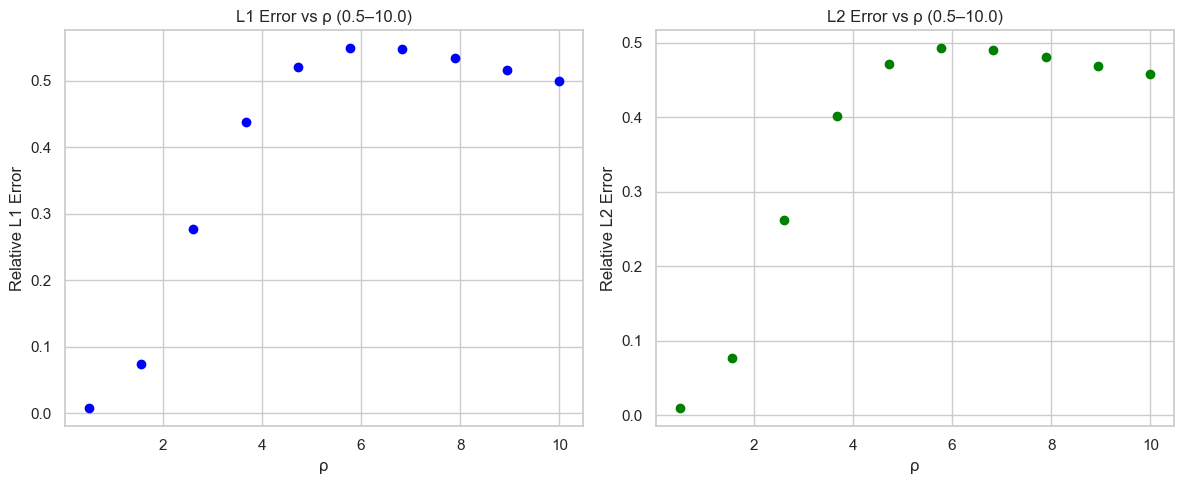

Pearson correlation (ρ vs L1): 0.823
Pearson correlation (ρ vs L2): 0.824


In [20]:
# Example usage loop over different rho ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]
dataset = ODEData(t_range=[0, 1], rho_values=[0.1, 0.3, 0.4], t_points=101, constant_x=1.0, device='cuda:0') # here we can use dummy rho values

for start, end in ranges:
    rho_vals = generate_rho_values(start, end, num=10)
    df_results = evaluate_rho_range(rho_vals, dataset, best_model, device='cuda:0')
    visualize_error_vs_rho(df_results, range_label=f"{start}–{end}")

In [21]:
def compute_average_error_per_range(ranges, dataset, model, device='cuda:0', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        rho_values = np.linspace(start, end, points_per_range)
        df = evaluate_rho_range(rho_values, dataset, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [22]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

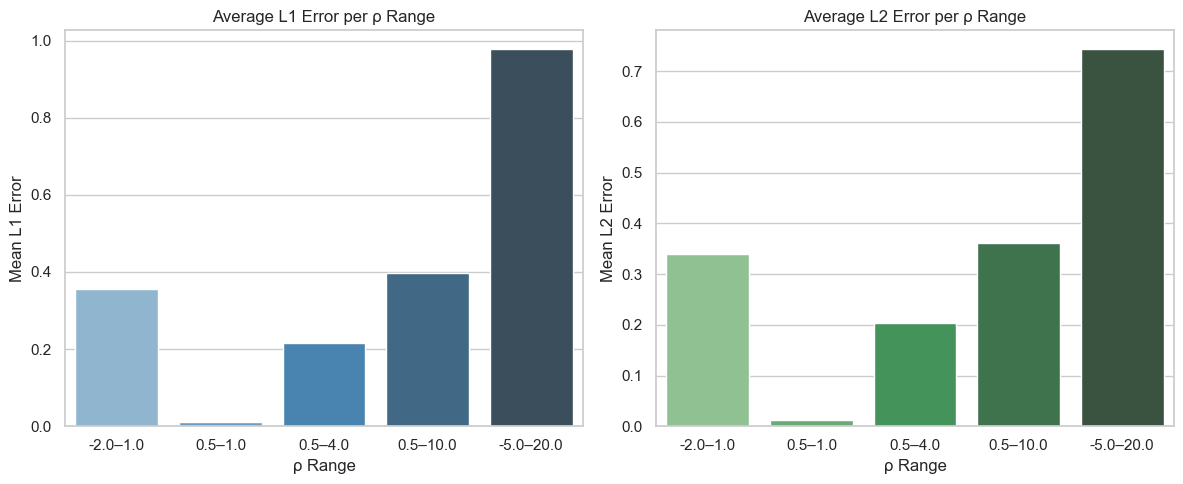

In [23]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, best_model, device='cuda:0')
plot_average_errors(df_avg)


### Analyzing convergence speed

In [39]:
import pandas as pd
import copy

In [46]:
print(best_model)

PINNff(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [47]:
def plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss']):
    """
    Plot convergence comparisons for multiple rho values.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        metrics (list): List of metrics to plot (default: ['rl2', 'loss'])

    Returns:
        matplotlib.figure.Figure: The generated figure with subplots
    """
    num_rhos = len(experiment_results)
    num_metrics = len(metrics)

    fig, axes = plt.subplots(num_metrics, num_rhos, figsize=(5*num_rhos, 4*num_metrics))
    if num_metrics == 1 and num_rhos == 1:
        axes = np.array([[axes]])
    elif num_metrics == 1:
        axes = np.array([axes])
    elif num_rhos == 1:
        axes = np.array([[ax] for ax in axes])

    for metric_idx, metric in enumerate(metrics):
        for rho_idx, result in enumerate(experiment_results):
            ax = axes[metric_idx, rho_idx]
            target_rho = result['target_rho']
            baseline_metrics = result['baseline_metrics']
            finetune_metrics = result['finetune_metrics']
            ax.plot(
                baseline_metrics['iterations'],
                baseline_metrics[metric],
                'b-o',
                label=f'From Scratch'
            )
            ax.plot(
                finetune_metrics['iterations'],
                finetune_metrics[metric],
                'r-o',
                label=f'Fine-tuned'
            )

            ax.set_xlabel('Iterations')
            ax.set_ylabel(f'{metric.upper()}')
            ax.set_title(f'ρ={target_rho}')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_yscale('log')  # Log scale better shows convergence differences

            if rho_idx == 0:
                ax.legend()

    plt.tight_layout()
    return fig

def calculate_all_convergence_metrics(experiment_results, threshold=0.3):
    """
    Calculate convergence metrics for all experiments.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        threshold (float): Error threshold for determining convergence

    Returns:
        pandas.DataFrame: DataFrame with convergence metrics
    """
    all_comparisons = []

    for result in experiment_results:
        target_rho = result['target_rho']
        baseline_metrics = result['baseline_metrics']
        finetune_metrics = result['finetune_metrics']

        # Find iterations where models first reach error threshold
        try:
            baseline_converged_at = next(i for i, v in enumerate(baseline_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            baseline_converged_at = "Did not converge"

        try:
            finetune_converged_at = next(i for i, v in enumerate(finetune_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            finetune_converged_at = "Did not converge"

        if isinstance(baseline_converged_at, int) and isinstance(finetune_converged_at, int):
            speedup = (baseline_converged_at / finetune_converged_at) if finetune_converged_at > 0 else float('inf')
            speedup_percentage = ((baseline_converged_at - finetune_converged_at) / baseline_converged_at) * 100
        else:
            speedup = "N/A"
            speedup_percentage = "N/A"

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Baseline (From Scratch)',
            'Final RL1 Error': baseline_metrics['rl1'][-1],
            'Final RL2 Error': baseline_metrics['rl2'][-1],
            'Iterations to Converge': baseline_converged_at
        })

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Fine-tuned',
            'Final RL1 Error': finetune_metrics['rl1'][-1],
            'Final RL2 Error': finetune_metrics['rl2'][-1],
            'Iterations to Converge': finetune_converged_at,
            'Speedup Factor': speedup,
            'Improvement %': speedup_percentage if isinstance(speedup_percentage, (int, float)) else speedup_percentage
        })

    return pd.DataFrame(all_comparisons)

In [48]:
def write_experiment_summary(experiment_results, output_file='fine_tuning_summary.txt', threshold=0.8):
    """
    Write a summary of fine-tuning experiment results to a text file.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        output_file (str or Path): Path to the output summary file
        threshold (float): Error threshold for convergence determination
    """

    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as summary_file:
        summary_file.write("=== Summary of Findings ===\n\n")

        for result in experiment_results:
            target_rho = result['target_rho']
            baseline_l2 = result['baseline_metrics']['rl2'][-1]
            finetune_l2 = result['finetune_metrics']['rl2'][-1]

            # Calculate improvement percentage
            improvement = ((baseline_l2 - finetune_l2) / baseline_l2) * 100

            # Write to file
            summary_file.write(f"Rho = {target_rho}:\n")
            summary_file.write(f"  - From scratch final RL2: {baseline_l2:.6f}\n")
            summary_file.write(f"  - Fine-tuned final RL2: {finetune_l2:.6f}\n")
            summary_file.write(f"  - Error reduction: {improvement:.2f}%\n")

            # Try to identify if convergence threshold was reached
            try:
                baseline_converged_at = next(i for i, v in enumerate(result['baseline_metrics']['rl2']) if v < threshold)
                baseline_converged = True
            except StopIteration:
                baseline_converged = False

            try:
                finetune_converged_at = next(i for i, v in enumerate(result['finetune_metrics']['rl2']) if v < threshold)
                finetune_converged = True
            except StopIteration:
                finetune_converged = False

            if baseline_converged and finetune_converged:
                if finetune_converged_at == 0:
                    # Handle the case where fine-tuned model converged immediately
                    summary_file.write(f"  - Fine-tuned model already met threshold - immediate convergence!\n")
                    summary_file.write(f"  - Baseline model converged in {baseline_converged_at} iterations.\n")
                elif baseline_converged_at == 0:
                    # Handle case where baseline model converged immediately
                    summary_file.write(f"  - Both models converged immediately - they already met the threshold.\n")
                else:
                    # Normal case - both converged after some iterations
                    speedup = baseline_converged_at / finetune_converged_at
                    summary_file.write(f"  - Convergence speedup: {speedup:.2f}x (iterations: {finetune_converged_at} vs {baseline_converged_at})\n")
            elif finetune_converged and not baseline_converged:
                summary_file.write(f"  - Only fine-tuned model converged (in {finetune_converged_at} iterations)\n")
            elif baseline_converged and not finetune_converged:
                summary_file.write(f"  - Only baseline model converged (in {baseline_converged_at} iterations)\n")
            else:
                summary_file.write(f"  - Neither model converged to threshold {threshold}\n")

            summary_file.write("\n")

        # Add timestamp
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        summary_file.write(f"\nSummary generated on: {timestamp}")

In [49]:
def run_fine_tuning_experiment(target_rho, best_model, iterations=50, device='cuda:0'):
    """
    Run a fine-tuning experiment comparing from-scratch training vs fine-tuning
    for a specific target rho value using PINN FF model.

    Args:
        target_rho (float): The target rho value to fine-tune on
        best_model (nn.Module): The pre-trained PINN FF model to fine-tune
        iterations (int): Number of training iterations
        device (str): Device to run training on

    Returns:
        dict: Contains baseline_metrics and finetune_metrics
    """
    # Create a `from_scratch` model with same architecture but default weights
    from_scratch_model = copy.deepcopy(best_model)
    from_scratch_model.apply(init_weights)
    
    # Create a model for fine-tuning (properly copy the pre-trained model)
    finetuned_model = copy.deepcopy(best_model)

    # Configure optimizers
    from_scratch_optimizer = torch.optim.Adam(from_scratch_model.parameters(), lr=1e-3)
    finetune_optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-3)

    # Configure dataset with only the target rho - NO time sequencing for PINN FF
    dataset = ODEData(
        t_range=[0, 1],
        rho_values=[target_rho],
        t_points=101,
        constant_x=1.0,
        device=device
    )

    # Configure training settings
    model_config_dict = {
        "total_i": iterations,
        "batch_size": 32,
        "normalize_res": False,
        "normalize_ic": False,
        "adaptive_loss_weighting": False,
        "adaptive_loss_coeff": 0.9,
        "alpha": 1.0,
        "epsilon": 1e-8
    }

    # Tracking structures for comparing convergence
    baseline_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}
    finetune_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}

    # Train from scratch
    model_config_dict["mode"] = "from_scratch"
    print(f"Training baseline model from scratch for ρ={target_rho}...")
    baseline_loss_track, baseline_avg_l1, baseline_avg_l2 = run_training(
        model_config_dict,
        from_scratch_model,
        from_scratch_optimizer,
        dataset,
        [target_rho],
        device
    )

    # Fine-tune pre-trained model
    model_config_dict["mode"] = "fine_tuned"
    print(f"Fine-tuning pre-trained model for ρ={target_rho}...")
    finetune_loss_track, finetune_avg_l1, finetune_avg_l2 = run_training(
        model_config_dict,
        finetuned_model,
        finetune_optimizer,
        dataset,
        [target_rho],
        device
    )

    # Extract metrics for plotting (same as before)
    for i, metrics in baseline_loss_track.items():
        baseline_metrics['iterations'].append(i)
        baseline_metrics['loss'].append(metrics['avg_total_loss'])
        baseline_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        baseline_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    for i, metrics in finetune_loss_track.items():
        finetune_metrics['iterations'].append(i)
        finetune_metrics['loss'].append(metrics['avg_total_loss'])
        finetune_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        finetune_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    return {
        'target_rho': target_rho,
        'baseline_metrics': baseline_metrics,
        'finetune_metrics': finetune_metrics,
        'baseline_l1': baseline_avg_l1,
        'baseline_l2': baseline_avg_l2,
        'finetune_l1': finetune_avg_l1,
        'finetune_l2': finetune_avg_l2
    }

In [50]:
def init_weights(m):
    """Initialize model weights for PINN FF network."""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

""" # Create PINN FF model
def create_pinn_ff_model(in_dim=3, hidden_dim=128, out_dim=1, num_layer=6, 
                         init_act_func="sin", subseq_activ_func="tanh", device="cuda:0"):
    
    model = PINNff(
        in_dim=in_dim,
        hidden_dim=hidden_dim,
        out_dim=out_dim,
        num_layer=num_layer,
        init_act_func=init_act_func,
        subseq_activ_func=subseq_activ_func
    ).to(device)
    return model

# Example usage:
best_model = create_pinn_ff_model(device=device) """

' # Create PINN FF model\ndef create_pinn_ff_model(in_dim=3, hidden_dim=128, out_dim=1, num_layer=6, \n                         init_act_func="sin", subseq_activ_func="tanh", device="cuda:0"):\n\n    model = PINNff(\n        in_dim=in_dim,\n        hidden_dim=hidden_dim,\n        out_dim=out_dim,\n        num_layer=num_layer,\n        init_act_func=init_act_func,\n        subseq_activ_func=subseq_activ_func\n    ).to(device)\n    return model\n\n# Example usage:\nbest_model = create_pinn_ff_model(device=device) '

Training baseline model from scratch for ρ=0.5...


100%|██████████| 60/60 [00:04<00:00, 14.36it/s]


Fine-tuning pre-trained model for ρ=0.5...


100%|██████████| 60/60 [00:04<00:00, 12.93it/s]


Training baseline model from scratch for ρ=1.0...


100%|██████████| 60/60 [00:03<00:00, 15.51it/s]


Fine-tuning pre-trained model for ρ=1.0...


100%|██████████| 60/60 [00:04<00:00, 14.34it/s]


Training baseline model from scratch for ρ=3.0...


100%|██████████| 60/60 [00:04<00:00, 14.36it/s]


Fine-tuning pre-trained model for ρ=3.0...


100%|██████████| 60/60 [00:04<00:00, 13.35it/s]


Training baseline model from scratch for ρ=4.0...


100%|██████████| 60/60 [00:04<00:00, 14.14it/s]


Fine-tuning pre-trained model for ρ=4.0...


100%|██████████| 60/60 [00:03<00:00, 15.10it/s]


Training baseline model from scratch for ρ=5.0...


100%|██████████| 60/60 [00:04<00:00, 14.24it/s]


Fine-tuning pre-trained model for ρ=5.0...


100%|██████████| 60/60 [00:04<00:00, 14.23it/s]


Training baseline model from scratch for ρ=6.0...


100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Fine-tuning pre-trained model for ρ=6.0...


100%|██████████| 60/60 [00:04<00:00, 13.27it/s]


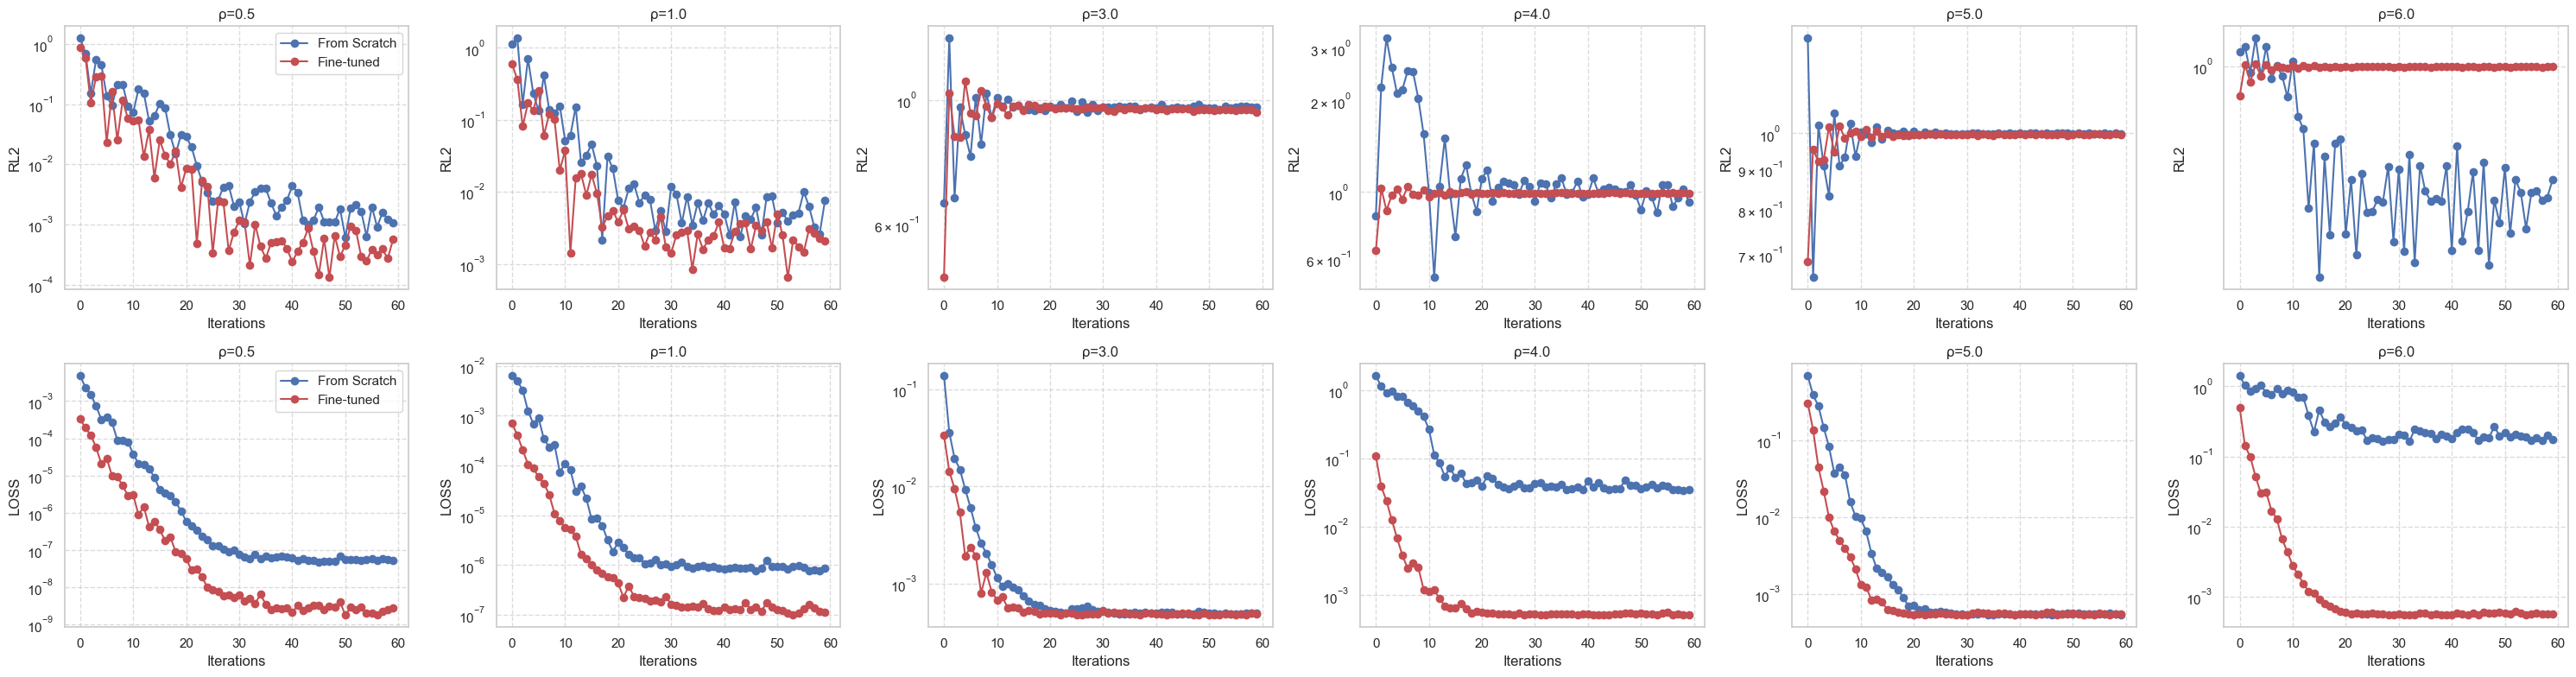

In [52]:

# Define target rho values for fine-tuning experiments
target_rho_values = [0.5, 1.0, 3.0, 4.0, 5.0, 6.0]
fine_tuning_iterations = 60
device = 'cuda:0'

# Set output directories
base_dir = Path(".") / "low_regime"  
convergence_dir = base_dir / "convergence"
convergence_dir.mkdir(parents=True, exist_ok=True)

# Load pre-trained PINN FF model (assuming it's already trained)
# If you need to train it first:
# best_model = train_best_model(rho_values=[0.1, 0.5, 1.0, 2.0, 3.0], device=device)

experiment_results = []
for target_rho in target_rho_values:
    result = run_fine_tuning_experiment(
        target_rho=target_rho,
        best_model=best_model,
        iterations=fine_tuning_iterations,
        device=device
    )
    experiment_results.append(result)

# The rest of the code (metrics calculation, plotting, summary writing) can remain the same
all_metrics_df = calculate_all_convergence_metrics(experiment_results)
all_metrics_df.to_csv(convergence_dir / 'multi_rho_convergence_metrics.csv', index=False)

fig = plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss'])
fig.savefig(convergence_dir / 'multi_rho_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

write_experiment_summary(
    experiment_results,
    output_file=convergence_dir / 'fine_tuning_summary.txt',
    threshold=0.05
)